In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
tf.__version__
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


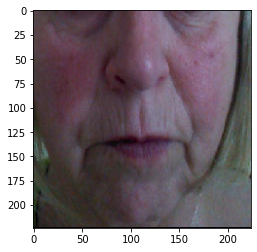

In [18]:
#carregar imagem pessoa com lupus
image = tf.keras.preprocessing.image.load_img(r'/content/drive/My Drive/Lupus_Skin_detection/train/positivo/20.jpg', target_size=(224,224))
plt.imshow(image);

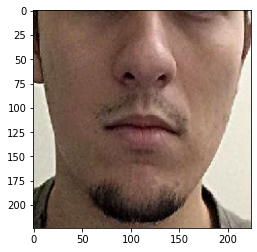

In [5]:
#carregar imagem pessoa sem lupus
image = tf.keras.preprocessing.image.load_img(r'/content/drive/My Drive/Lupus Skin Detection/semlupus/1.jpg', target_size=(224, 224))
plt.imshow(image);

In [6]:
#aumentando dataset
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)

#batsize de 16 pois o treinamento vai ser feito de 16 em 16 imagens
train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Lupus_Skin_detection/train',
                                                    target_size = (224, 224),
                                                    batch_size=16,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 136 images belonging to 2 classes.


In [9]:
train_generator.n


136

In [10]:
train_generator.batch_size

16

In [11]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_train

8

In [13]:
#base de teste

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) #faz normalização
test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/Lupus_Skin_detection/test',
                                                  target_size=(224,244),
                                                  batch_size=1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)



Found 52 images belonging to 2 classes.


In [14]:
step_size_test = test_generator.n // test_generator.batch_size
step_size_test

52

In [19]:
#modelo base para transfer learning usando o resnet50, o motivo pq é o unico que sei usar de rede já treinada

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)



94773248/94765736 [==============================] - 1s 0us/step


In [20]:
#estrutura da resnet 50
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [21]:
x = base_model.output #aqui recebe a ultima camada da resnet50

In [22]:
#aqui faço um pooling maroto para fazer uma média global da ultima camada da resnet e faz uma redução de dimensionalidade
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [23]:
#definindo as camadas densas

x = tf.keras.layers.Dense(1024, activation='relu')(x) #1024 neuronios
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x) #softmax retorna probablidade de cada classe, pq é para ver se pessoa tem ou não a doença


In [24]:
#terminando a rede neural juntando a resnet com as camadas densas de antes
model = tf.keras.Model(inputs = base_model.input, outputs = preds)

In [25]:
#estrutura da nova rede neural criada 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [26]:
#mostrar total de camadas para fazer o fine tuning
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [27]:
#começa o fine tuning do transfer learning congelo as camadas até a numero 175
for layer in model.layers[:175]:
  layer.trainable = False  

In [28]:
#agora começo o treinamento da camada 175
for layer in model.layers[175:]:
  layer.trainable = True  

In [29]:

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
#fazer o treinamento 
history = model.fit_generator(generator=train_generator,
                              epochs=20,
                              steps_per_epoch=step_size_train,
                              validation_data = test_generator,
                              validation_steps=step_size_test)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
8/8 [==============================] - 127s 16s/step - loss: 1.7495 - accuracy: 0.6167 - val_loss: 0.4831 - val_accuracy: 0.8269
Epoch 2/20
8/8 [==============================] - 4s 440ms/step - loss: 0.4801 - accuracy: 0.7500 - val_loss: 0.3179 - val_accuracy: 0.8462
Epoch 3/20
8/8 [==============================] - 3s 418ms/step - loss: 0.3218 - accuracy: 0.8417 - val_loss: 0.2765 - val_accuracy: 0.8462
Epoch 4/20
8/8 [==============================] - 3s 428ms/step - loss: 0.2274 - accuracy: 0.9250 - val_loss: 0.4234 - val_accuracy: 0.8462
Epoch 5/20
8/8 [==============================] - 4s 450ms/step - loss: 0.2226 - accuracy: 0.9000 - val_loss: 0.2284 - val_accuracy: 0.8654
Epoch 6/20
8/8 [==============================] - 3s 413ms/step - loss: 0.2449 - accuracy: 0.9167 - val_loss: 0.2120 - val_accuracy: 0.9423
Epoch 7/20
8/8 [==============================] - 3s 425ms/step - loss: 0.1189 - acc

In [31]:
#média da acuracia 
np.mean(history.history['val_accuracy'])

0.898076918721199

In [33]:
#desvio padrão
np.std(history.history['val_accuracy'])

0.05374302773545727

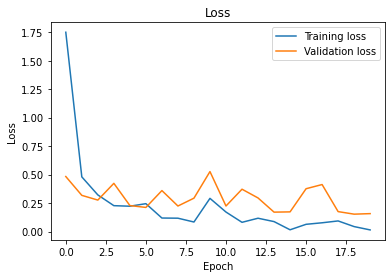

In [34]:
#verificar a variação do erro
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

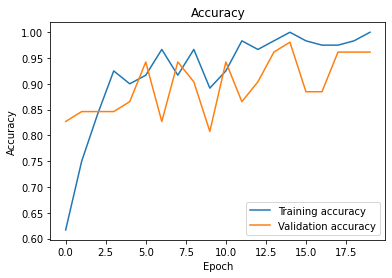

In [35]:
#percentual de acerto
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend();

In [36]:
#busca o nome de arquivos da base de teste
filenames = test_generator.filenames
filenames

['negativo/Neg62.jpg',
 'negativo/Neg63.jpg',
 'negativo/Neg73.jpg',
 'negativo/Neg74.jpg',
 'negativo/Neg83.jpg',
 'negativo/Neg84.jpg',
 'negativo/Neg85.jpg',
 'negativo/Neg87.jpg',
 'negativo/Neg88.jpg',
 'negativo/Neg89.jpg',
 'negativo/Neg90.jpg',
 'negativo/Neg91.jpg',
 'negativo/Neg92.jpg',
 'negativo/Neg95.jpg',
 'negativo/Neg98.jpg',
 'negativo/Neg99.jpg',
 'positivo/1.jpg',
 'positivo/100.jpg',
 'positivo/109.jpg',
 'positivo/11.jpg',
 'positivo/114.jpg',
 'positivo/117.jpg',
 'positivo/119.jpg',
 'positivo/123.jpg',
 'positivo/124.jpg',
 'positivo/19.jpg',
 'positivo/21.jpg',
 'positivo/22.jpg',
 'positivo/23.jpg',
 'positivo/27.jpg',
 'positivo/3.jpg',
 'positivo/30.jpg',
 'positivo/34.jpg',
 'positivo/36.jpg',
 'positivo/39.jpg',
 'positivo/40.jpg',
 'positivo/45.jpg',
 'positivo/46.jpg',
 'positivo/5.jpg',
 'positivo/50.jpg',
 'positivo/56.jpg',
 'positivo/68.jpg',
 'positivo/69.jpg',
 'positivo/76.jpg',
 'positivo/77.jpg',
 'positivo/8.jpg',
 'positivo/87.jpg',
 'positiv

In [37]:
len(filenames)

52

In [38]:
predictions = model.predict_generator(test_generator, steps = len(filenames))


Instructions for updating:
Please use Model.predict, which supports generators.


In [39]:
predictions

array([[9.9875379e-01, 1.2462592e-03],
       [9.9682224e-01, 3.1777751e-03],
       [9.9812955e-01, 1.8705034e-03],
       [8.7143397e-01, 1.2856609e-01],
       [9.9939489e-01, 6.0513744e-04],
       [9.9996591e-01, 3.4046370e-05],
       [9.9088961e-01, 9.1103222e-03],
       [9.0762490e-01, 9.2375062e-02],
       [6.1673951e-01, 3.8326052e-01],
       [9.9949670e-01, 5.0325255e-04],
       [9.9974507e-01, 2.5496486e-04],
       [9.9525416e-01, 4.7458983e-03],
       [9.9791437e-01, 2.0855810e-03],
       [1.5331186e-01, 8.4668809e-01],
       [9.9890232e-01, 1.0976483e-03],
       [6.3003635e-01, 3.6996368e-01],
       [7.7227509e-05, 9.9992275e-01],
       [3.8029245e-06, 9.9999619e-01],
       [9.9296123e-01, 7.0387525e-03],
       [4.9505902e-06, 9.9999499e-01],
       [8.6085021e-07, 9.9999917e-01],
       [2.3046738e-02, 9.7695321e-01],
       [3.3314782e-03, 9.9666852e-01],
       [2.2400054e-05, 9.9997759e-01],
       [1.0168784e-03, 9.9898309e-01],
       [1.6867017e-02, 9.

In [40]:
predictions2 = []
for i in range(len(predictions)):
  #print(predictions[i])
  predictions2.append(np.argmax(predictions[i]))

In [41]:
predictions2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [42]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [43]:
test_generator.class_indices

{'negativo': 0, 'positivo': 1}

In [44]:
#score de quanto ele acerto e fazer matriz de confusão
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(predictions2, test_generator.classes)

0.9615384615384616

In [45]:
cm = confusion_matrix(predictions2, test_generator.classes)
cm

array([[15,  1],
       [ 1, 35]])

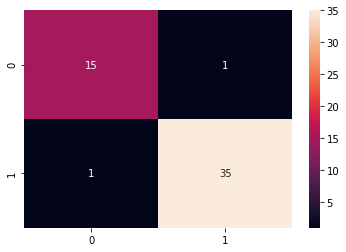

In [46]:
sns.heatmap(cm, annot=True); #matriz de confusão lindona pelo seaborn

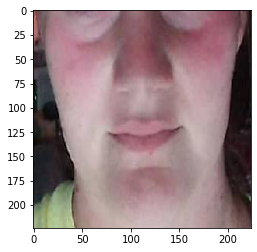

In [47]:
#testando com imagem

#testando pessoa que tem lupus
image = tf.keras.preprocessing.image.load_img(r'/content/drive/My Drive/Lupus_Skin_detection/test/positivo/117.jpg', target_size=(224,224))
plt.imshow(image);


In [48]:
#passar imagem pra array pq tensorflow é uma bosta
image = tf.keras.preprocessing.image.img_to_array(image)
np.shape(image)

(224, 224, 3)

In [49]:
np.max(image), np.min(image) #ver valores maximos e minimos da imagem

(221.0, 0.0)

In [50]:
#pra ver a previsão no tensorflow a iamgem tem que ta nesse formato
image = np.expand_dims(image, axis = 0)
np.shape(image)

(1, 224, 224, 3)

In [51]:
image = tf.keras.applications.resnet50.preprocess_input(image)
np.max(image), np.min(image)

(101.221, -123.68)

In [52]:
predictions = model.predict(image)
print(predictions)

[[0.00696386 0.9930361 ]]


In [53]:
predictions[0]

array([0.00696386, 0.9930361 ], dtype=float32)

In [54]:
np.argmax(predictions[0])

1

In [55]:
list(train_generator.class_indices)

['negativo', 'positivo']

In [56]:
prediction = list(train_generator.class_indices)[np.argmax(predictions[0])]
prediction

'positivo'